In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datacleaner import *
from abc import ABC
import pandas as pd
import os
from torch_geometric.data import Dataset
from torch_geometric.utils import from_networkx
import torch
import networkx as nx
import numpy as np
import dgl
from tqdm import tqdm
import wandb

In [2]:
def get_cleaned_df():
    df = get_dataframe()
    
    #Count the number of diagnosis risk factors
    icd9_cols = df.filter(regex='^icd9').columns

    # Find all columns with age of diagnoses
    age_cols = df.filter(regex='admit_age').columns
    age_cols = age_cols[:-1] #don't get the HF age cause we don't want to drop that one

    # Find all columns with icu stay of diagnoses
    icu_cols = df.filter(regex='icu_stay').columns

    # Find columns associated with echo data
    echo_cols = ['height', 'weight', 'bpsys', 'bpdias', 'hr', 'EF']
    
    #Create a new dataframe that has the groupings
    grouped_df = pd.DataFrame()

    # group the diagnoses
    for i in range(len(icd9_cols)):
        # stack the three columns into a single list column
        df['new_'+icd9_cols[i]] = df.apply(lambda x: [x[icd9_cols[i]], x[age_cols[i]], x[icu_cols[i]]], axis=1)
        grouped_df['new_'+icd9_cols[i]] = (df['new_'+icd9_cols[i]])
        df.drop(('new_'+icd9_cols[i]), axis=1)
        
    #group all echo variables with age and echo_icu_stay
    for i in range(len(echo_cols)):
        # stack the three columns into a single list column
        df['new_'+echo_cols[i]] = df.apply(lambda x: [x[echo_cols[i]], x['age'], x['echo_icu_stay']], axis=1)
        grouped_df['echo_'+echo_cols[i]] = (df['new_'+echo_cols[i]])
        df.drop('new_'+echo_cols[i], axis=1)
        
    #add gender - standalone
    # replace 'M' and 'F' with 1 and 2, respectively
    df['gender'] = df['gender'].replace({'M': 1, 'F': 2})
    grouped_df['gender'] = df.apply(lambda x: [x['gender'], 0, 0], axis=1)

    #add target HF
    grouped_df['HF'] = df['target_HF']
    
    return grouped_df


grouped_df = get_cleaned_df()
val_size = 0.1
test_size = 0.1
# split data into training and test sets
train_data, test_data = train_test_split(grouped_df, test_size=test_size)
train_data, val_data = train_test_split(train_data, test_size=val_size/(1-test_size))

The number of negative values in target_HF column is: 12479
The number of positive values in target_HF column is: 7917


In [3]:
len(train_data.columns)

47

In [4]:
class MIMICDataset(Dataset, ABC):
    def __init__(self, data_df):

        super().__init__()
        
        # Extract the features and labels
        features_tensor = torch.tensor([], dtype=torch.float)
        labels_tensor = torch.tensor([], dtype=torch.long)
        
        # Extract the labels
        self.labels = torch.tensor(data_df['HF'].tolist(), dtype=torch.long)
        
        # Extract the image data
        self.data = torch.FloatTensor(data_df.loc[:, data_df.columns != 'HF'].values.tolist())
        #print(self.data.shape)
        
        # Find the proportion of each digit in the set
        self.class_weights = 1 / np.unique(self.labels, return_counts=True)[1]
        #print(np.unique(self.labels, return_counts=True)[1])
        self.class_weights = self.class_weights[self.labels]
        #print(self.class_weights)
        
        self.nx_graph = nx.complete_graph(46) 
        
        self.num_samples = data_df.shape[0]    

    def get(self, idx):

        # Retrieve the sample
        sample_features = self.data[idx].view(46, -1).unsqueeze(0).unsqueeze(0) #TODO

        # Retrieve the label
        label = self.labels[idx]

        # Create the PyG data from the graph structure
        #g = from_networkx(self.nx_graph)
        #g = dgl.from_networkx(nx_g)
        # Create DGL graph from networkx
        g = from_networkx(self.nx_graph)

        # Add data and label to the PyG data
        g.y = label
        g.features = sample_features
        g.nx_graph = nx.complete_graph(46) 

        return g

    def len(self) -> int:
        return self.num_samples

In [5]:
train_dataset = MIMICDataset(train_data)
val_dataset = MIMICDataset(val_data)
test_dataset = MIMICDataset(test_data)

/var/folders/x4/_sfmqqbj0sq0f3v44_gt4f7h0000gn/T/ipykernel_69662/2760376088.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.labels = torch.tensor(data_df['HF'].tolist(), dtype=torch.long)


In [6]:
print("The training set has {} samples.".format(len(train_dataset)))
print("The training set has {} samples.".format(len(val_dataset)))
print("The test set has {} samples.".format(len(test_dataset)))

The training set has 16316 samples.
The training set has 2040 samples.
The test set has 2040 samples.


In [7]:
from torch.utils.data import WeightedRandomSampler
from torch.optim import Adam
import torch.nn as nn
from torch_geometric.nn import MessagePassing, Sequential, GCNConv, global_add_pool, global_mean_pool
from sklearn.metrics import accuracy_score
import numpy as np
import time

from math import floor
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [8]:
num_samples = 128
batch_size = 128
train_sampler = WeightedRandomSampler(weights=train_dataset.class_weights, num_samples=len(train_dataset), 
                                      replacement=False)
val_sampler = WeightedRandomSampler(weights=val_dataset.class_weights, num_samples=len(val_dataset), 
                                      replacement=False)                                      
test_sampler = WeightedRandomSampler(weights=test_dataset.class_weights, num_samples=len(test_dataset), 
                                     replacement=False)


In [24]:
trainloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)#,sampler=train_sampler)
valloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)#sampler=val_sampler)
testloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)#sampler=test_sampler)

In [25]:
class GCNClassifier(nn.Module):
    def __init__(self,
                 input_feature_dim,
                 dropout_p,
                 gnn_hidden_dims,
                 mlp_hidden_dim,
                 num_classes):
        super().__init__()

        self.layers = nn.ModuleList()

        # GNN layers
        for gnn_hidden_dim in gnn_hidden_dims:
            self.layers.append(Sequential('x, edge_index', [(GCNConv(in_channels=input_feature_dim,
                                                                     out_channels=gnn_hidden_dim), 'x, edge_index -> x'),
                                                            nn.BatchNorm1d(gnn_hidden_dim),
                                                            nn.Dropout(p=dropout_p),
                                                            nn.ReLU(inplace=True)]))
            input_feature_dim = gnn_hidden_dim

        # Output MLP layers
        self.output_mlp = nn.Sequential(nn.Linear(in_features=gnn_hidden_dims[-1],
                                                  out_features=mlp_hidden_dim),
                                        nn.BatchNorm1d(mlp_hidden_dim),
                                        nn.Dropout(p=dropout_p),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(in_features=mlp_hidden_dim,
                                                  out_features=num_classes),
                                        nn.Sigmoid())
        

    def forward(self, g):
        h = g.features.squeeze()
        
        # Compute min and max values for each feature
        min_values, _ = torch.min(h, dim=0, keepdim=True)
        max_values, _ = torch.max(h, dim=0, keepdim=True)

        # Add small epsilon to denominator to prevent division by zero
        epsilon = 1e-8
        denominator = max_values - min_values + epsilon

        # Normalize each feature
        h = (h - min_values) / denominator

        h = torch.reshape(h, [h.shape[0]*h.shape[1], -1])
        #print(h.shape)
        edge_index = g.edge_index
        #print(edge_index.shape)
        
        # GNN layers
        for gnn_layer in self.layers:
            h = gnn_layer(h, edge_index)

        # Pool node embeddings to create the graph embedding
        h = global_mean_pool(h, g.batch)

        # Output MLP
        h = self.output_mlp(h)
        h = h.squeeze()

        return h
        

In [26]:
gnn_classifiers = GCNClassifier(input_feature_dim=3, #TODO
                                dropout_p=0.3,
                                gnn_hidden_dims=[64, 64],
                                mlp_hidden_dim=64,
                                num_classes=1)

print(gnn_classifiers)

GCNClassifier(
  (layers): ModuleList(
    (0): Sequential(
      (0): GCNConv(3, 64)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): GCNConv(64, 64)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): ReLU(inplace=True)
    )
  )
  (output_mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [27]:
# Create the loss function and the optimizer
optimizer = Adam(list(gnn_classifiers.parameters()), lr=0.001)
loss_func = nn.BCELoss()

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.01, min_lr=0.000001)


In [28]:
epochs=100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

#wandb.init(project='ELEC571_Project', entity='vctoriawu')

for epoch in range(epochs):

    train_time = time.time()
    train_loss = 0
    train_preds = []
    train_labels = []
    
    for i, data_batch in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()

        # Use GNN layers to propagate messages between embeddings #TODO - define data_batch.x and data_batch.y
        h = data_batch.features
        #h = h.view(batch_size, -1)
        #h = torch.reshape(h, [h.shape[0]*h.shape[1]*h.shape[2], -1])
        #h = torch.squeeze(h, dim=1)
        #h = torch.reshape(h, [h.shape[0], h.shape[2]*h.shape[3], h.shape[1]])
        #print(h.shape)
        data_batch.x = h
        x = gnn_classifiers(data_batch)
        y = data_batch.y
        y = y.type(torch.float)
        #x = torch.squeeze(x, dim=1)
        #print(x)
        loss = loss_func(x, y)
        train_loss += loss.item() * batch_size

        loss.backward()
        optimizer.step()

        # Save label and prediction
        #data_batch.y.detach().cpu().numpy()
        #prediction = x.detach().cpu().numpy().round()
        
        prediction = x > 0.5
        
        train_preds.extend(prediction.tolist())
        train_labels.extend(data_batch.y.tolist())

    train_time = time.time() - train_time
    
    # Update the learning rate
    #lr_scheduler.step()

    val_loss = 0
    val_preds = []
    val_labels = []
    
    test_time = time.time()
    
    with torch.no_grad():
        for i, data_batch in enumerate(tqdm(valloader)):

            # Use GNN layers to propagate messages between pixel embeddings
            h = data_batch.features
            #h = torch.squeeze(h, dim=1)
            data_batch.x = h
            x = gnn_classifiers(data_batch)
            y = data_batch.y
            y = y.type(torch.float)
            #x = torch.squeeze(x, dim=1)
            loss = loss_func(x, y)
            val_loss += loss.detach().cpu().item() * batch_size

            # Save label and prediction
            data_batch.y.detach().cpu().numpy()
            prediction = x.detach().cpu().numpy().round()
            
            val_preds.extend(prediction.tolist())
            val_labels.extend(data_batch.y.tolist())
            
    val_acc = accuracy_score(val_labels, val_preds)
    train_acc = accuracy_score(train_labels, train_preds)
    

    test_time = time.time() - test_time
    
    # Append losses and accuracies to lists for plotting
    train_loss /= len(trainloader)*batch_size
    val_loss /= len(valloader)*batch_size
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Update the scheduler based on the validation loss
    scheduler.step(val_loss)

    # Print epoch information
    #wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc})
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 1/100, Train Loss: 0.6042, Val Loss: 0.5871, Train Acc: 0.6698, Val Acc: 0.6917


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 2/100, Train Loss: 0.5958, Val Loss: 0.5907, Train Acc: 0.6807, Val Acc: 0.6937


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 3/100, Train Loss: 0.5958, Val Loss: 0.5831, Train Acc: 0.6785, Val Acc: 0.6943


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 4/100, Train Loss: 0.5937, Val Loss: 0.5882, Train Acc: 0.6799, Val Acc: 0.6911


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 5/100, Train Loss: 0.5934, Val Loss: 0.5779, Train Acc: 0.6794, Val Acc: 0.7089


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 6/100, Train Loss: 0.5931, Val Loss: 0.5867, Train Acc: 0.6812, Val Acc: 0.7068


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 7/100, Train Loss: 0.5921, Val Loss: 0.5844, Train Acc: 0.6826, Val Acc: 0.7000


100%|███████████████████████████████████████████| 15/15 [00:16<00:00,  1.10s/it]


Epoch 8/100, Train Loss: 0.5924, Val Loss: 0.5795, Train Acc: 0.6805, Val Acc: 0.6995


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 9/100, Train Loss: 0.5916, Val Loss: 0.5796, Train Acc: 0.6822, Val Acc: 0.6995


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 10/100, Train Loss: 0.5916, Val Loss: 0.5824, Train Acc: 0.6801, Val Acc: 0.6880


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 11/100, Train Loss: 0.5903, Val Loss: 0.5830, Train Acc: 0.6836, Val Acc: 0.6953


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.12it/s]


Epoch 12/100, Train Loss: 0.5911, Val Loss: 0.5818, Train Acc: 0.6807, Val Acc: 0.7036


100%|███████████████████████████████████████████| 15/15 [00:16<00:00,  1.12s/it]


Epoch 13/100, Train Loss: 0.5907, Val Loss: 0.5818, Train Acc: 0.6804, Val Acc: 0.7016


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 14/100, Train Loss: 0.5900, Val Loss: 0.5797, Train Acc: 0.6820, Val Acc: 0.7016


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 15/100, Train Loss: 0.5902, Val Loss: 0.5814, Train Acc: 0.6799, Val Acc: 0.6969


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 16/100, Train Loss: 0.5907, Val Loss: 0.5851, Train Acc: 0.6812, Val Acc: 0.6906


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 17/100, Train Loss: 0.5912, Val Loss: 0.5800, Train Acc: 0.6828, Val Acc: 0.6974


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 18/100, Train Loss: 0.5895, Val Loss: 0.5822, Train Acc: 0.6812, Val Acc: 0.6901


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 19/100, Train Loss: 0.5908, Val Loss: 0.5817, Train Acc: 0.6833, Val Acc: 0.6969


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 20/100, Train Loss: 0.5893, Val Loss: 0.5827, Train Acc: 0.6823, Val Acc: 0.6943


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 21/100, Train Loss: 0.5914, Val Loss: 0.5851, Train Acc: 0.6820, Val Acc: 0.6927


100%|███████████████████████████████████████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 22/100, Train Loss: 0.5904, Val Loss: 0.5832, Train Acc: 0.6839, Val Acc: 0.6870


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 23/100, Train Loss: 0.5899, Val Loss: 0.5812, Train Acc: 0.6809, Val Acc: 0.6958


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 24/100, Train Loss: 0.5912, Val Loss: 0.5773, Train Acc: 0.6803, Val Acc: 0.6927


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 25/100, Train Loss: 0.5895, Val Loss: 0.5798, Train Acc: 0.6820, Val Acc: 0.7026


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 26/100, Train Loss: 0.5905, Val Loss: 0.5802, Train Acc: 0.6828, Val Acc: 0.7000


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch 27/100, Train Loss: 0.5913, Val Loss: 0.5792, Train Acc: 0.6791, Val Acc: 0.7047


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 28/100, Train Loss: 0.5900, Val Loss: 0.5813, Train Acc: 0.6818, Val Acc: 0.6979


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 29/100, Train Loss: 0.5902, Val Loss: 0.5828, Train Acc: 0.6836, Val Acc: 0.6979


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 30/100, Train Loss: 0.5896, Val Loss: 0.5793, Train Acc: 0.6836, Val Acc: 0.7016


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch 31/100, Train Loss: 0.5901, Val Loss: 0.5831, Train Acc: 0.6815, Val Acc: 0.6958


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 32/100, Train Loss: 0.5892, Val Loss: 0.5817, Train Acc: 0.6829, Val Acc: 0.6964


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 33/100, Train Loss: 0.5899, Val Loss: 0.5857, Train Acc: 0.6810, Val Acc: 0.6906


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch 34/100, Train Loss: 0.5894, Val Loss: 0.5802, Train Acc: 0.6809, Val Acc: 0.6932


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 35/100, Train Loss: 0.5896, Val Loss: 0.5871, Train Acc: 0.6838, Val Acc: 0.6880


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 36/100, Train Loss: 0.5899, Val Loss: 0.5803, Train Acc: 0.6824, Val Acc: 0.6995


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 37/100, Train Loss: 0.5896, Val Loss: 0.5835, Train Acc: 0.6805, Val Acc: 0.6943


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch 38/100, Train Loss: 0.5907, Val Loss: 0.5817, Train Acc: 0.6799, Val Acc: 0.7016


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 39/100, Train Loss: 0.5894, Val Loss: 0.5798, Train Acc: 0.6842, Val Acc: 0.6964


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 40/100, Train Loss: 0.5907, Val Loss: 0.5879, Train Acc: 0.6802, Val Acc: 0.6927


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 41/100, Train Loss: 0.5900, Val Loss: 0.5909, Train Acc: 0.6806, Val Acc: 0.6818


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 42/100, Train Loss: 0.5906, Val Loss: 0.5860, Train Acc: 0.6816, Val Acc: 0.6969


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 43/100, Train Loss: 0.5897, Val Loss: 0.5832, Train Acc: 0.6811, Val Acc: 0.6953


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


Epoch 44/100, Train Loss: 0.5895, Val Loss: 0.5798, Train Acc: 0.6821, Val Acc: 0.6984


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch 45/100, Train Loss: 0.5900, Val Loss: 0.5818, Train Acc: 0.6805, Val Acc: 0.6969


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.00s/it]


Epoch 46/100, Train Loss: 0.5898, Val Loss: 0.5859, Train Acc: 0.6813, Val Acc: 0.6974


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 47/100, Train Loss: 0.5905, Val Loss: 0.5809, Train Acc: 0.6815, Val Acc: 0.6932


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch 48/100, Train Loss: 0.5901, Val Loss: 0.5845, Train Acc: 0.6818, Val Acc: 0.6943


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch 49/100, Train Loss: 0.5898, Val Loss: 0.5765, Train Acc: 0.6818, Val Acc: 0.7031


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 50/100, Train Loss: 0.5909, Val Loss: 0.5827, Train Acc: 0.6801, Val Acc: 0.6948


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 51/100, Train Loss: 0.5896, Val Loss: 0.5848, Train Acc: 0.6835, Val Acc: 0.6948


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 52/100, Train Loss: 0.5904, Val Loss: 0.5835, Train Acc: 0.6814, Val Acc: 0.6979


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch 53/100, Train Loss: 0.5904, Val Loss: 0.5814, Train Acc: 0.6802, Val Acc: 0.6974


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 54/100, Train Loss: 0.5894, Val Loss: 0.5829, Train Acc: 0.6826, Val Acc: 0.6953


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 55/100, Train Loss: 0.5896, Val Loss: 0.5781, Train Acc: 0.6826, Val Acc: 0.6969


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 56/100, Train Loss: 0.5909, Val Loss: 0.5859, Train Acc: 0.6819, Val Acc: 0.6932


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch 57/100, Train Loss: 0.5910, Val Loss: 0.5848, Train Acc: 0.6831, Val Acc: 0.6906


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 58/100, Train Loss: 0.5902, Val Loss: 0.5854, Train Acc: 0.6827, Val Acc: 0.6896


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 59/100, Train Loss: 0.5903, Val Loss: 0.5825, Train Acc: 0.6824, Val Acc: 0.7010


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 60/100, Train Loss: 0.5907, Val Loss: 0.5783, Train Acc: 0.6826, Val Acc: 0.7047


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


Epoch 61/100, Train Loss: 0.5901, Val Loss: 0.5836, Train Acc: 0.6832, Val Acc: 0.6979


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 62/100, Train Loss: 0.5908, Val Loss: 0.5826, Train Acc: 0.6840, Val Acc: 0.6922


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 63/100, Train Loss: 0.5892, Val Loss: 0.5838, Train Acc: 0.6845, Val Acc: 0.6943


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 64/100, Train Loss: 0.5906, Val Loss: 0.5803, Train Acc: 0.6809, Val Acc: 0.6990


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 65/100, Train Loss: 0.5894, Val Loss: 0.5772, Train Acc: 0.6829, Val Acc: 0.7068


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 66/100, Train Loss: 0.5899, Val Loss: 0.5776, Train Acc: 0.6823, Val Acc: 0.6964


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 67/100, Train Loss: 0.5893, Val Loss: 0.5861, Train Acc: 0.6831, Val Acc: 0.6932


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 68/100, Train Loss: 0.5909, Val Loss: 0.5824, Train Acc: 0.6802, Val Acc: 0.6901


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 69/100, Train Loss: 0.5903, Val Loss: 0.5801, Train Acc: 0.6821, Val Acc: 0.6969


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.07it/s]


Epoch 70/100, Train Loss: 0.5910, Val Loss: 0.5898, Train Acc: 0.6829, Val Acc: 0.6849


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


Epoch 71/100, Train Loss: 0.5903, Val Loss: 0.5808, Train Acc: 0.6817, Val Acc: 0.6990


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 72/100, Train Loss: 0.5905, Val Loss: 0.5856, Train Acc: 0.6813, Val Acc: 0.6901


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 73/100, Train Loss: 0.5897, Val Loss: 0.5829, Train Acc: 0.6845, Val Acc: 0.6990


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 74/100, Train Loss: 0.5908, Val Loss: 0.5844, Train Acc: 0.6818, Val Acc: 0.7000


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 75/100, Train Loss: 0.5894, Val Loss: 0.5810, Train Acc: 0.6858, Val Acc: 0.7010


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 76/100, Train Loss: 0.5905, Val Loss: 0.5821, Train Acc: 0.6807, Val Acc: 0.6964


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 77/100, Train Loss: 0.5895, Val Loss: 0.5776, Train Acc: 0.6819, Val Acc: 0.7005


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch 78/100, Train Loss: 0.5901, Val Loss: 0.5826, Train Acc: 0.6813, Val Acc: 0.6948


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 79/100, Train Loss: 0.5900, Val Loss: 0.5840, Train Acc: 0.6811, Val Acc: 0.6984


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.00it/s]


Epoch 80/100, Train Loss: 0.5888, Val Loss: 0.5753, Train Acc: 0.6841, Val Acc: 0.7073


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 81/100, Train Loss: 0.5894, Val Loss: 0.5903, Train Acc: 0.6836, Val Acc: 0.6901


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch 82/100, Train Loss: 0.5900, Val Loss: 0.5855, Train Acc: 0.6809, Val Acc: 0.6911


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch 83/100, Train Loss: 0.5904, Val Loss: 0.5840, Train Acc: 0.6829, Val Acc: 0.6958


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch 84/100, Train Loss: 0.5910, Val Loss: 0.5825, Train Acc: 0.6819, Val Acc: 0.6995


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 85/100, Train Loss: 0.5910, Val Loss: 0.5850, Train Acc: 0.6825, Val Acc: 0.6922


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.00s/it]


Epoch 86/100, Train Loss: 0.5899, Val Loss: 0.5856, Train Acc: 0.6854, Val Acc: 0.6917


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 87/100, Train Loss: 0.5905, Val Loss: 0.5750, Train Acc: 0.6820, Val Acc: 0.7016


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.07it/s]


Epoch 88/100, Train Loss: 0.5903, Val Loss: 0.5788, Train Acc: 0.6840, Val Acc: 0.6937


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 89/100, Train Loss: 0.5905, Val Loss: 0.5804, Train Acc: 0.6805, Val Acc: 0.6958


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 90/100, Train Loss: 0.5907, Val Loss: 0.5868, Train Acc: 0.6823, Val Acc: 0.6979


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 91/100, Train Loss: 0.5898, Val Loss: 0.5863, Train Acc: 0.6801, Val Acc: 0.7000


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch 92/100, Train Loss: 0.5914, Val Loss: 0.5800, Train Acc: 0.6801, Val Acc: 0.6964


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 93/100, Train Loss: 0.5899, Val Loss: 0.5823, Train Acc: 0.6855, Val Acc: 0.7052


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 94/100, Train Loss: 0.5909, Val Loss: 0.5823, Train Acc: 0.6818, Val Acc: 0.6984


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Epoch 95/100, Train Loss: 0.5899, Val Loss: 0.5804, Train Acc: 0.6831, Val Acc: 0.6974


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 96/100, Train Loss: 0.5899, Val Loss: 0.5817, Train Acc: 0.6834, Val Acc: 0.6964


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.00s/it]


Epoch 97/100, Train Loss: 0.5892, Val Loss: 0.5815, Train Acc: 0.6805, Val Acc: 0.6984


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch 98/100, Train Loss: 0.5894, Val Loss: 0.5832, Train Acc: 0.6832, Val Acc: 0.6896


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 99/100, Train Loss: 0.5897, Val Loss: 0.5813, Train Acc: 0.6793, Val Acc: 0.6964


100%|███████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]

Epoch 100/100, Train Loss: 0.5895, Val Loss: 0.5860, Train Acc: 0.6829, Val Acc: 0.6891


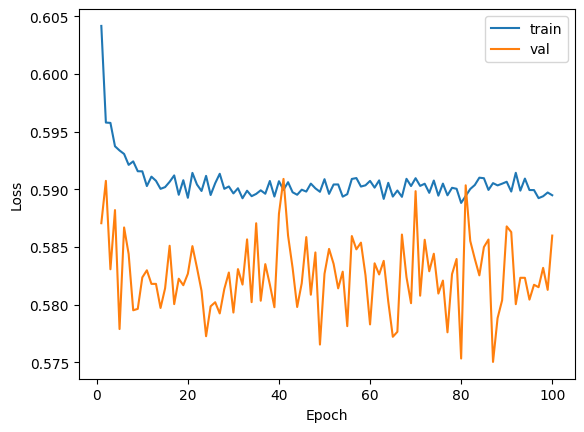

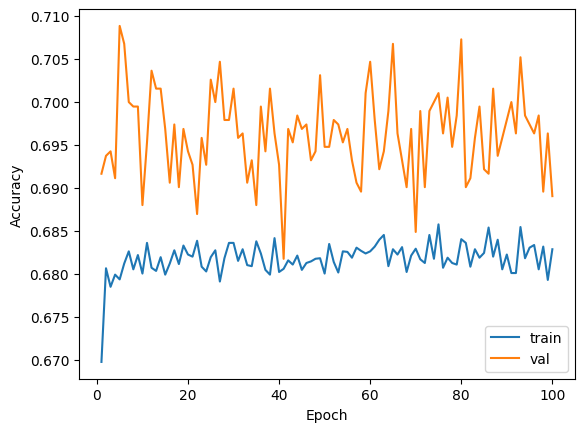

In [29]:
import matplotlib.pyplot as plt

# Plot the losses and accuracies
epochs = np.arange(1, 100+1)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accs, label='train')
plt.plot(epochs, val_accs, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [550]:
#weights = torch.load("weights.pth", map_location=torch.device('cpu'))

In [139]:
#gnn_classifiers.load_state_dict(weights)

<All keys matched successfully>

In [30]:
test_loss = 0
test_preds = []
test_labels = []

test_time = time.time()

with torch.no_grad():
    for i, data_batch in enumerate(tqdm(testloader)):

        # Use GNN layers to propagate messages between pixel embeddings
        data_batch.x = data_batch.features
        x = gnn_classifiers(data_batch)
        y = data_batch.y
        y = y.type(torch.float)
        loss = loss_func(x, y)
        test_loss += loss.detach().cpu().item() * batch_size

        # Save label and prediction
        data_batch.y.detach().cpu().numpy()
        prediction = x.detach().cpu().numpy().round()

        test_preds.extend(prediction.tolist())
        test_labels.extend(data_batch.y.tolist())

test_loss /= len(testloader)*batch_size
test_acc = accuracy_score(test_labels, val_preds)

print(test_acc)
print(test_loss)

100%|█████████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]

0.5286458333333334
0.6066328605016073


In [31]:
print(test_preds)

[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,